# Dating in New Jersey

## Intro

I was talking to a friend a while back, and he mentioned to me that "it is hard to meet people" in our area (Middlesex County, NJ). I decided to see if that is true or not.

To this end, I downloaded the state- and county-level data from the US Census Bureau to estimate the number of dating-age people (25-34) in our area compared to the rest of the country.

### Organization of this notebook

After importing packages and defining functions, I compare the population distribution of the USA as a whole to that of New York and New Jersey. I define a "youth fraction" to compare quantitavely the relative number of people aged 25-34 in various states and counties versus the United States average. For the curious, I also briefly discuss the "best" and "worst" counties in the country by this metric. I end with some obvious caveats of this analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import plotly.express as px
import re

%matplotlib inline

### Functions for reading in data 

In [2]:
def keep_col(name, sex='sex0'):
    """small function to decide which of the numerous columns to keep"""
    if (name.startswith('est72017')  # 2017 estimate
        and '999' not in name  # don't need totals, just by age
        and 'medage' not in name  # don't need median age
        and 'plus' not in name
        and not name.endswith('r')
        and sex in name):  # only want well-defined bins so we can normalize
        return True
    else:
        return False

In [3]:
def read_county_data(filename, sex='sex0', clean=True, **kwargs):
    """Read in census data for county by county and filter out age data.
    
    Assumes 5 year age intervals
    
    if clean(default True), remove "county" and state name from county"""
    df = pd.read_csv(filename, quotechar='"', skiprows=[1], 
                    index_col='GEO.display-label', **kwargs)
        
    # small function to rename columns of the type ageXtoX
    def rename_col(name):
        if 'age' in name:
            # get rid of things before "age"
            name = name[re.search('age', name).end():]
            # pick out the numbers in the column
            nums = re.findall('[0-9]{1,2}', name)
            # return the mean age in the bin
            return np.array(nums, dtype=int).mean()
        else:
            return name
        
    cols = [col for col in df.columns if 
            keep_col(col, sex)]
    
    people_df = df.loc[:, cols]
    people_df.columns = [rename_col(col) for col in people_df.columns]
    
    # some age bins overlap. we only want the first set, going up to max age
    # The age bins we want increase monotonically, so break when no longer increasing
    cols_to_keep = []
    for i in range(len(people_df.columns)):
        cols_to_keep.append(people_df.columns[i])
        try:
            diff = people_df.columns[i + 1] - people_df.columns[i]
            if diff < 0:
                break
        except TypeError:
            pass

    people_df = people_df.loc[:, cols_to_keep]
    #[[col for col in cols if sex in col]].iloc[:, :17]
#     five_years = 0.5* (np.arange(0, 90, 5)[1:] + np.arange(0, 90, 5)[:-1])
#     people_df.columns = five_years
    if clean:
        people_df.index = clean_county(people_df)
    
    return people_df

In [4]:
def clean_county(df):
    """Remove state in 'County, [State Name]' from index'"""
    df.index = [' '.join(county.split(',')[0].split()[:-1]) for county in df.index]
    return df.index

In [5]:
def state_slice(df, states):
    """Return county information for one or more states
    
    Returns either one state or list of states"""
    # test if string or list
    try:
        test = states.split()
        states = [states]
    except AttributeError:
        pass
    states = [counties.loc[[ind for ind in counties.index if 'County, ' + state in ind]].copy() 
              for state in states]
    for state in states:
        state.index = clean_county(state)
    if len(states) == 1:
        return states[0]
    else:
        return states

This metric (the youth fraction) is defined below.

In [6]:
def fraction(df, reference, low=25, high=35):
    """Calculate log youth fraction (low <= age < high)
    
    df : the dataframe
    reference : the data to which fraction is compared to (i.e., USA fraction)"""
    
    df = (df.drop(columns=['Fraction']) if 'Fraction' in df.columns else df).copy()
    reference = (reference.drop(index=['Fraction']) if 'Fraction' in reference.index else reference).copy()
    
#     try:
#         cols_as_float = df.columns.astype(float)
#     # in this case, the last column is the fraction, not
#     # a population, and shouldn't be included in the sum
#     except:
#         df = df.iloc[:, :-1].copy()
#         reference = reference[:-1].copy()
    mask = ((df.columns.astype(float) < high) 
            & (df.columns.astype(float) >= low))
    maskref = ((reference.index.astype(float) < high) 
               & (reference.index.astype(float) >= low))
        
    reference_frac = (reference.loc[maskref].sum() / reference.sum()).copy()
    fraction = (df.loc[:, mask].sum(axis=1) / df.sum(axis=1) / reference_frac)

    return np.log10(fraction)

In [7]:
def to_percent(eta):
    """Convert eta to a percentage difference from the reference"""
    eta = np.array(eta)
    return (10**eta - 1) * 100

In [8]:
def to_eta(percent):
    """Convert a percentage difference from the reference to eta"""
    percent = np.array(percent)
    return np.log10(percent / 100.0 + 1)

## Reading in data, and taking a few specific states as examples 

#### County-level data, which is provided in 5-year age increments

I additionally combine the five boroughs of New York City into one entity for reference

In [9]:
counties = read_county_data('counties/PEP_2017_PEPAGESEX_with_ann.csv', encoding="ISO-8859-1", clean=False)

In [10]:
nj, ny, il, tn = state_slice(counties, ['New Jersey', 'New York', 'Illinois', 'Tennessee'])
ny.loc['NYC'] = ny.loc[[x for x in ['Kings', 'Queens', 'Richmond', 'New York', 'Bronx']]].sum(axis=0)

#### State-level data, which is provided in 1-year age increments

In [11]:
df = pd.read_csv('PEP_2017_PEPSYASEX_with_ann.csv', skiprows=[1], index_col='GEO.display-label')

cols = [col for col in df.columns if 
        keep_col(col, 'sex0')]

allpeople = df.loc[:, cols]

# modifying column names
all_years = np.arange(0, 85, 1)
allpeople.columns = all_years

### A first look

Let's compare New Jersey and New York, as well as Middlesex County and NYC

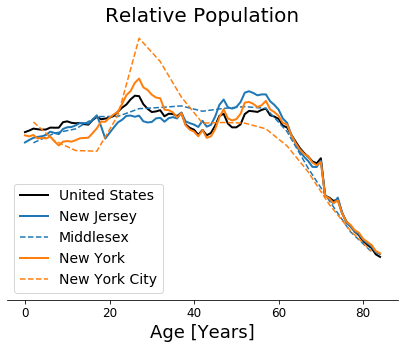

In [12]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5)
ax.plot(all_years, allpeople.loc['United States'] / allpeople.loc['United States'].sum(),
       label='United States', color='k', lw=2)
ax.plot(all_years, allpeople.loc['New Jersey'] / allpeople.loc['New Jersey'].sum(),
       label='New Jersey', lw=2)
# divide by 5 because bins are 5 years instead of 1
ax.plot(nj.columns, nj.loc['Middlesex'] / 5 / nj.loc['Middlesex'].sum(),
       label='Middlesex', color='C0', ls='--')
ax.plot(all_years, allpeople.loc['New York'] / allpeople.loc['New York'].sum(),
       label='New York', lw=2)
ax.plot(ny.columns, ny.loc['NYC'] / 5 / ny.loc['NYC'].sum(),
       label='New York City', color='C1', ls='--')
# ax.plot(il.columns, il.loc['Cook'] / 5 / il.loc['Cook'].sum(),
#        label='Cook County', ls='--')
ax.set_xlabel('Age [Years]', fontsize=18)
ax.legend(loc='lower left', fontsize=14)
ax.set_ylim([0, 0.02])
ax.tick_params(labelsize=12)
ax.tick_params('y', labelleft=False, left=False)
ax.set_title('Relative Population', fontsize=20)
for pos in ['left', 'right', 'top']:
    ax.spines[pos].set_visible(False)

# fig.savefig('figures/total_pop_with_NJ_NY_NYC.png', dpi=300)

Looking at the above figure, we see features in the USA population - the bump around 60 years old among the baby boomers, and a general decline after that age. Compared to the USA as a whole, New Jersey seems to have more baby boomers and fewer young people, while New York (and especially NYC) have a very large overabundance of people 25-34.

One may assume everyone from NJ of dating age has moved to New York! But let's dig deeper...

#### The "youth fraction"

This metric will be used later. It is defined as

\begin{equation}
\eta_\mathrm{R}(s)\equiv\mathrm{log}_{10}\frac{N_{s,[25,34]}/N_{s,\mathrm{tot}}}{N_{\mathrm{R},[25,34]}/N_\mathrm{R,tot}},
\end{equation}

where $s$ is the county or state of interest, and R is a reference region to which the number of dating-age people is compared. The rest of this notebook takes R=USA, or the USA population average. We use this metric so that deviations are symmetric - a factor of 2 increase is the same as a factor of 2 decrease.

Thus, $\eta_\mathrm{USA}(\mathrm{NJ})=-0.028$, meaning New Jersey (since $10^{-0.28}=0.063$) about 6.3% below the US national average in terms of number of people between 25 and 34.


In [13]:
low, high = 25, 35
allpeople['Fraction'] = fraction(allpeople, allpeople.loc['United States'], low=low, high=high)
ny['Fraction'] = fraction(ny, allpeople.loc['United States'], low=low, high=high)
nj['Fraction'] = fraction(nj, allpeople.loc['United States'], low=low, high=high)
il['Fraction'] = fraction(il, allpeople.loc['United States'], low=low, high=high)
tn['Fraction'] = fraction(tn, allpeople.loc['United States'], low=low, high=high)
counties['Fraction'] = fraction(counties,  allpeople.loc['United States'], low=low, high=high)

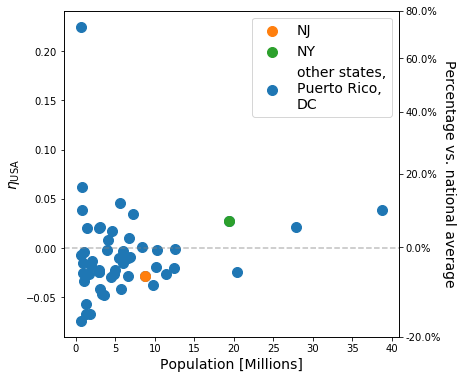

In [14]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 6)

ax.axhline(0, alpha=0.5, color='grey', ls='--')
ax.scatter(allpeople.loc['New Jersey'].sum() / 1e6, 
           allpeople.loc['New Jersey', 'Fraction'], s=100, 
           label='NJ', color='C1')
ax.scatter(allpeople.loc['New York'].sum() / 1e6, 
           allpeople.loc['New York', 'Fraction'], s=100, 
           label='NY', color='C2')
# exclude total US (first row) and 'Fraction' (last column)
ax.scatter(allpeople.iloc[1:, :-1].sum(axis=1) / 1e6, 
           allpeople.iloc[1:]['Fraction'], s=100, label='other states,\nPuerto Rico,\nDC',
           zorder=0, color='C0')

ax.set_xlabel('Population [Millions]', fontsize=14)
ax.set_ylabel('$\eta_\mathrm{USA}$', fontsize=14)

ax2 = ax.twinx()
eta_lims = to_percent(ax.set_ylim())
percents = [-20, 0, 20, 40, 60, 80]
ax2.set_ylim(ax.set_ylim())
ax2.set_yticks(to_eta(percents))
ax2.set_yticklabels([f'{percent:.1f}%' for percent in percents])
ax2.set_ylabel('Percentage vs. national average', fontsize=14, rotation=270, labelpad=15)

ax.legend(loc='upper right', fontsize=14)

The above plot shows that there seems to be little correlation, if any, between the population of a state and its youth fraction. The dashed line is the national average, while the colored points are NJ and NY. That very high point is DC, visible in the next plot.

Text(0.5, 0, 'Percent above national average')

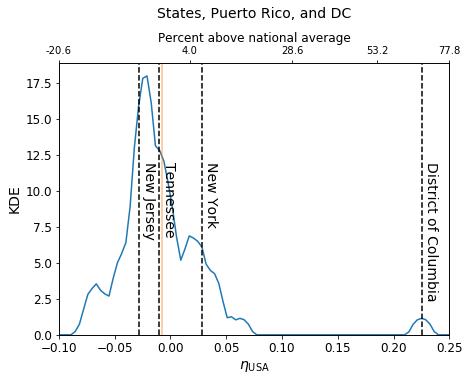

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5)

sns.kdeplot(allpeople.iloc[1:]['Fraction'], ax=ax, kernel='epa', label='', legend=False) 
for place in ['District of Columbia', 'New Jersey', 'New York', 'Tennessee']:
    ax.axvline(allpeople.loc[place, 'Fraction'], color='k', ls='--')
    ax.text(allpeople.loc[place, 'Fraction'] + 0.0025, 12, place, 
            va='top', rotation=270, fontsize=14)
ax.set_xlim([-0.1, 0.25])
ax.axvline(allpeople['Fraction'].iloc[1:].mean(), color='C1', alpha=0.5)

ax.set_xlabel('$\eta_\mathrm{USA}$', fontsize=14)
ax.set_ylabel('KDE', fontsize=14)
ax.set_title('States, Puerto Rico, and DC', fontsize=14, pad=45)
ax.tick_params(labelsize=12)

ax2 = ax.twiny()
eta_lims = to_percent(ax.set_xlim())
percents = np.linspace(eta_lims[0], eta_lims[1], 5)
ax2.set_xlim(ax.set_xlim())
ax2.set_xticks(to_eta(percents))
ax2.set_xticklabels(['{:.1f}'.format(percent) for percent in percents])
ax2.set_xlabel('Percent above national average', fontsize=12)

# fig.savefig('figures/state_kde.png', dpi=300)

The above plot is a kernel density estimate (KDE) of states (and Puerto Rico and DC), so you can view it as a probability distribution of states as a function of their youth fraction.

In [16]:
pearsonr = ss.pearsonr(np.log10(counties.iloc[:, :-1].sum(axis=1)), counties['Fraction'])
mean_frac = np.mean(counties['Fraction'])
slope, const = np.polyfit(np.log10(counties.iloc[:, :-1].sum(axis=1)), counties['Fraction'], 1)

In [17]:
print(pearsonr[0])
print(mean_frac)

0.47354399348663195
-0.07223482618574752


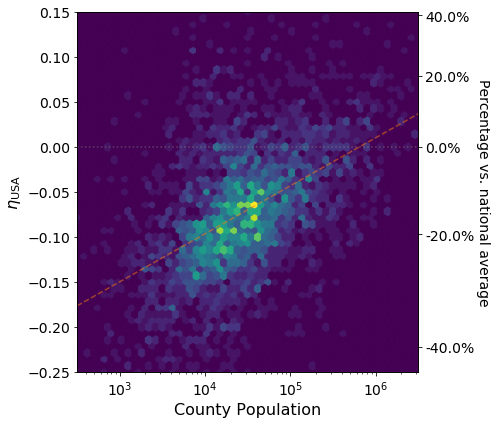

In [18]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 6)

ax.hexbin(counties.iloc[:, :-1].sum(axis=1), counties['Fraction'], xscale='log', 
          extent=[2.5, 6.5, -0.25, 0.15], gridsize=50)
ax.set_xlim([10**2.5, 10**6.5])
ax.set_ylim([-0.25, 0.15])
ax.set_xlabel('County Population', fontsize=16)
ax.set_ylabel('$\eta_\mathrm{USA}$', fontsize=16)
ax.tick_params(labelsize=14)
ax.axhline(0, alpha=0.5, color='grey', ls='dotted')
ax.plot(10**np.linspace(2.5, 6.5, 100), slope * np.linspace(2.5, 6.5, 100) + const, 
        color='C1', ls='--', alpha=0.5)

ax2 = ax.twinx()
ax2.tick_params(labelsize=14)
eta_lims = to_percent(ax.set_ylim())
percents = [-40, -20, 0, 20, 40]
ax2.set_ylim(ax.set_ylim())
ax2.set_yticks(to_eta(percents))
ax2.set_yticklabels([f'{percent:.1f}%' for percent in percents])
ax2.set_ylabel('Percentage vs. national average', fontsize=14, rotation=270, labelpad=15)

fig.tight_layout()

# fig.savefig('figures/frac_vs_pop.png', dpi=300)

On the county level, there is a strong correlation between (log$_{10}$) population and youth fraction (best-fit line is drawn as dashed line, pearsonr is 0.46). It seems that more populous counties have more people age 25-34, and that the majority of counties fall below the national average (national average drawn as horizontal dotted line). This implies, then, that young people are disproportionately concentrated in populous counties (AKA cities).

Text(0.5, 0, 'Percentage vs. national average')

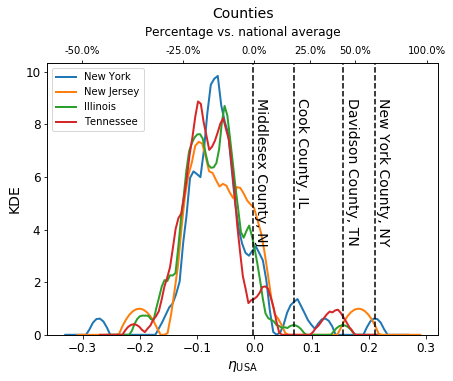

In [19]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5)

sns.kdeplot(ny.iloc[:-1]['Fraction'], ax=ax, kernel='epa', 
            label='New York', lw=2) #exclude "NYC", not a county
sns.kdeplot(nj['Fraction'], ax=ax, kernel='epa', label='New Jersey', lw=2)
sns.kdeplot(il['Fraction'], ax=ax, kernel='epa', label='Illinois', lw=2)
sns.kdeplot(tn['Fraction'], ax=ax, kernel='epa', label='Tennessee', lw=2)
# sns.kdeplot(va['Fraction'], ax=ax, kernel='epa', label='Virginia', lw=2)
for place, state, frame in zip(['Middlesex', 'New York', 'Cook', 'Davidson'], 
                               ['NJ', 'NY', 'IL', 'TN'],
                               [nj, ny, il, tn]):
    ax.axvline(frame.loc[place, 'Fraction'], color='k', ls='--')
    ax.text(frame.loc[place, 'Fraction'] + 0.0025, 9, f'{place} County, {state}', 
            va='top', rotation=270, fontsize=14)

ax.set_xlabel('$\eta_\mathrm{USA}$', fontsize=14)
ax.set_ylabel('KDE', fontsize=14)
ax.set_title('Counties', fontsize=14, pad=45)
ax.tick_params(labelsize=12)

ax2 = ax.twiny()
eta_lims = to_percent(ax.set_xlim())
percents = [-50, -25, 0, 25, 50, 100]
ax2.set_xlim(ax.set_xlim())
ax2.set_xticks(to_eta(percents))
ax2.set_xticklabels([f'{percent:.1f}%' for percent in percents])
ax2.set_xlabel('Percentage vs. national average', labelpad=10, fontsize=12)

# fig.savefig('figures/county_kde.png', dpi=300)

Interestingly, it seems these four example states all have similar distributions of youth fraction at the county level, with peak and mean well below the national average, and only a few counties above.

To answer the original question posed by my friend --- is it harder to meet people in our area --- it turns out the answer is no. We are almost exactly at the national average, which means we fare better than the majority of counties in not only New Jersey, but the entire country.

### Out of curiosity, what are the lowest and highest youth fractions?

In [20]:
counties.sort_values('Fraction').iloc[list(range(5)) + list(range(-5, 0, 1)), [-1]]

,Fraction
GEO.display-label,
"McPherson County, Nebraska",-0.403157
"Ontonagon County, Michigan",-0.389451
"Sumter County, Florida",-0.367902
"Catron County, New Mexico",-0.356120
"Alcona County, Michigan",-0.306408
"Suffolk County, Massachusetts",0.221663
"District of Columbia, District of Columbia",0.225069
"San Francisco County, California",0.230420
"Chattahoochee County, Georgia",0.241704


If you look at the lowest 5, most of them are very small (a few thousand residents), rural counties. This fits the trend we observed above. Sumter County, on the other hand, has over 100,000 people. However, it has experienced enormous recent population growth due to the expansion of The Villages retirement complex.

Among the top 5, most of them are in large metropolitan areas. Chattahoochee, however, is a rather small county. However, it is home to Fort Benning US Army post, which may contribute to its overabundance of people aged 25-34.

## Caveats

This analysis has many caveats, and should not be taken too seriously. Assumptions and issues include:

+ The "difficulty of meeting people" is ssumed to be a one-to-one function of the number of people. This is not true, and other factors may include:
    + Number of single/married people
    + Strength of community institutions in the area, such as social and religious organizations
    + Age at which people get married
    + etc
+ I weighted states equally and counties equally, and really should weight them by population (in other words, I could try to redefine $\eta$ such that the best-fit line between population and $\eta$ is horizontal). Instead of comparing the difficulty of meeting people in our county compared to other counties, I could compare with the different populations in mind.